# Crime rate and Funding visualized

In [28]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('seaborn')

In [29]:
#params
FP_SAFETY_DATA = os.path.join('data','safety_funding.csv')
FP_FIG_SPENDING_VS_CRIME_OUT = os.path.join('plots','spending_vs_crime.svg')
FP_FIG_SPENDING_OUT = os.path.join('plots','spending.svg')
assert os.path.exists(FP_SAFETY_DATA)
## NPD list of comparable cities
comp = ['Brookline', 
        'Cambridge',
        'Framingham',
        'Malden',
        'Medford',
        'Melrose',
        'Quincy',
        'Somerville',
        'Waltham',
        'Watertown']

In [30]:
df = pd.read_csv(FP_SAFETY_DATA,delimiter='\t')
df['Police Budget per capita'] = df['Police Budget per capita'].str.replace('$','').astype(float)
newton_mask = df.name=='Newton'
newton = df[newton_mask]
df = df.loc[:23].infer_objects().sort_index(ascending=False).reset_index(drop=True)

18

In [31]:
df

,name,Population,"Total Crime Rate (per 1,000 residents)",Violent Crime Rate,Property Crime Rate,Police Officers,"Officers per 10,000 residents",Police Employees,"Employees per 10,000 residents",2020 Police Budget,Police Budget per capita
0,Waltham,62979,11.90,2.00,9.90,142.0,22.3,170.0,26.7,"$20,270,701.00",321.86
1,Brookline,59234,11.70,1.00,10.80,129.0,21.7,153.0,25.7,"$17,386,626.00",293.52
2,Belmont,26330,6.60,0.20,6.50,46.0,17.9,60.0,23.4,"$7,472,519.00",283.80
3,Watertown,35954,8.70,0.80,8.00,67.0,19.3,71.0,20.5,"$9,960,086.00",277.02
4,Milton,27616,2.70,0.40,2.30,NaN,NaN,NaN,NaN,"$7,439,070.00",269.38
5,Newton,88904,7.80,0.70,7.20,149.0,16.7,195.0,21.9,"$22,804,754.00",256.51
6,Marshfield,25905,4.50,1.30,3.20,46.0,17.9,49.0,19.1,"$5,954,122.00",229.84
7,Somerville,80434,14.80,2.20,12.60,129.0,16.2,162.0,20.3,"$18,242,995.00",226.81
8,Needham,31248,5.20,0.50,4.70,46.0,15.0,55.0,17.9,"$7,063,740.00",226.05
9,Lexington,33792,3.60,0.20,3.40,47.0,14.0,61.0,18.1,"$7,567,030.00",223.93


In [32]:
df.dtypes

name                                       object
Population                                 object
Total Crime Rate (per 1,000 residents)    float64
Violent Crime Rate                        float64
Property Crime Rate                       float64
Police Officers                           float64
Officers per 10,000 residents             float64
Police Employees                          float64
Employees per 10,000 residents            float64
2020 Police Budget                         object
Police Budget per capita                  float64
dtype: object

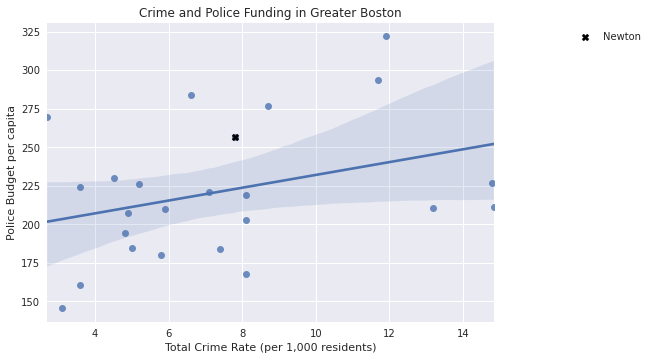

In [49]:
x = 'Total Crime Rate (per 1,000 residents)'
y = 'Police Budget per capita'
sns.regplot(data=df,
            x=x,
            y=y)
plt.scatter(newton[x],
            newton[y],
            marker='X',
            color='k',
            label='Newton')
plt.title('Crime and Police Funding in Greater Boston')
plt.legend(bbox_to_anchor = [1.35,1.0])
# plt.savefig(FP_FIG_SPENDING_VS_CRIME_OUT)



In [34]:
pdspending = 'Police Budget per capita'
crime = 'Total Crime Rate (per 1,000 residents)'

In [14]:
df[pdspending].median()

215.28

In [47]:
newton_at_median = (newton[pdspending] - df[pdspending].median())*int(newton.Population)
print(f'median spending is {df[pdspending].median()}')
print(f'Newton spends ${np.round(newton_at_median.values[0],2)} more than the median level of police spending')

median spending is 215.28
Newton spends $3665511.92 more than the median level of police spending


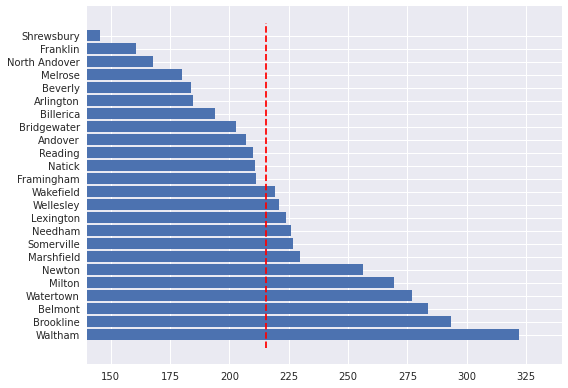

In [46]:
# plt.figure(figsize=[3.5,5])
# plt.hlines(df[pdspending].median(),-.1,0.1,label='median')
# plt.scatter([0],newton[pdspending],marker='d',s=20,label='Newton')
plt.figure()
ax=plt.gca()
y_pos = np.arange(len(df))
plt.barh(y_pos,df[pdspending])
ax.set_yticks(y_pos)
ax.set_yticklabels(df.name);
plt.xlim(140,340)
plt.vlines(df[pdspending].median(),min(y_pos)-1,max(y_pos)+1,'r',ls='--')
plt.tight_layout()
# plt.savefig(FP_FIG_SPENDING_OUT)

# Field Interrogations and Observations
2015- May 2020


In [50]:
# Params
FP_FIO = 'data/FIO.csv'
FP_DEMOGRAPHICS = 'data/newton_demographics.csv'

FP_FIO_BYRACE_OUT = 'analysis/fio_byrace.csv'
FP_FIG_FIO_COUNT_OUT = 'plots/fio_allstops_proportional_to_race.svg'

assert os.path.exists(FP_FIO)
assert os.path.exists(FP_DEMOGRAPHICS)

#demographic map
demo_map = {'W':'White',
            'B':'Black or African American',
            'A':'Asian',
            'I':'American Indian and Alaska Native',
            'H':'Hispanic or Latino (of any race)',
            'U':'unknown'}
map_demo_label = lambda demo_abbrev: demo_map[demo_abbrev]

In [51]:
fio = pd.read_csv(FP_FIO)
fio.head()

,Date/Time,Type/Offense,Location,Race,Gender,Age,Reason,Officer Initiated
0,9/12/2015 20:49,FIO,ALBEMARLE RD & NORTH ST (NV),W,M,75,Call for a male sleeping on a bench,No
1,9/24/2015 18:39,FIO,PARKER ST & WHEELER RD,B,F,25,Call For Solicitors in the Area Ringing Doorbells,No
2,10/6/2015 13:31,FIO,WABASSO ST,W,M,52,Call for tents in the woods off of Wabasso St,No
3,10/6/2015 13:31,FIO,WABASSO ST,W,F,45,Call for tents in the woods off of Wabasso St,No
4,11/28/2015 0:37,FIO,41 CLARENDON ST,W,M,18,Stopped after a call for B&E M/V,No


In [52]:
demo = pd.read_csv(FP_DEMOGRAPHICS,usecols=['demographic','Newton'])
#aggregate demographics not listed in FIOs as "unknown"
unknown_demos = ['Native Hawaiian and Other Pacific Islander','Some other race','Two or more races']
unknown_mask = [demographic in unknown_demos for demographic in demo.demographic]
demo.loc[8,:] = ['unknown',demo[unknown_mask].Newton.sum()]
demo = demo.set_index('demographic').drop(labels=unknown_demos).reset_index()
demo.columns=['demographic','demo_proportion']
demo

,demographic,demo_proportion
0,White,0.803
1,Black or African American,0.035
2,American Indian and Alaska Native,0.001
3,Asian,0.130
4,Hispanic or Latino (of any race),0.049
5,unknown,0.031


In [53]:
fio_byrace = fio.groupby('Race').count()['Date/Time'].reset_index()
fio_byrace['Race'] = fio_byrace.Race.apply(map_demo_label)
fio_byrace.columns=['demographic','count']
fio_byrace['count_proportion'] = fio_byrace['count']/len(fio)

fio_byrace = fio_byrace.set_index('demographic').join(demo.set_index('demographic'))

#calculate FIO stops proportionally
count_proportionally = lambda x : x[1]/x[2]
fio_byrace['stop_liklihood'] = fio_byrace.apply(count_proportionally,raw=True,axis=1)

In [54]:
fio_byrace.round(3).to_csv(FP_FIO_BYRACE_OUT)

In [55]:
ratio_blktowhite = fio_byrace.loc['Black or African American'].stop_liklihood / fio_byrace.loc['White'].stop_liklihood
print(f'If you are Black in Newton, you are {np.round(ratio_blktowhite,3)} times more likely to have field interactions with the police than a white person')

If you are Black in Newton, you are 7.315 times more likely to have field interactions with the police than a white person


In [56]:
ratio_lattowhite = fio_byrace.loc['Hispanic or Latino (of any race)'].stop_liklihood / fio_byrace.loc['White'].stop_liklihood
print(f'If you are Latinx in Newton, you are {np.round(ratio_lattowhite,3)} times more likely to have field interactions with the police than a white person')

If you are Latinx in Newton, you are 1.425 times more likely to have field interactions with the police than a white person


### What about officer initiated??

In [57]:
# get count of number of officer initated stops
fio.groupby('Officer Initiated').Reason.count()

Officer Initiated
No     136
Yes     74
Name: Reason, dtype: int64

In [58]:
fio_initiated = fio.groupby('Officer Initiated').get_group('Yes')

In [59]:
fio_initiated_byrace = fio_initiated.groupby('Race').count()['Date/Time'].reset_index()
fio_initiated_byrace['Race'] = fio_initiated_byrace.Race.apply(map_demo_label)
fio_initiated_byrace.columns=['demographic','count']
fio_initiated_byrace['count_proportion'] = fio_initiated_byrace['count']/len(fio_initiated)

fio_initiated_byrace = fio_initiated_byrace.set_index('demographic').join(demo.set_index('demographic'))

#calculate FIO stops proportionally
# count_proportionally = lambda x : x[1]/x[2]
fio_initiated_byrace['stop_liklihood'] = fio_initiated_byrace.apply(count_proportionally,raw=True,axis=1)

In [60]:
fio_initiated_byrace

,count,count_proportion,demo_proportion,stop_liklihood
demographic,,,,
Asian,1,0.013514,0.130,0.103950
Black or African American,18,0.243243,0.035,6.949807
Hispanic or Latino (of any race),7,0.094595,0.049,1.930502
unknown,2,0.027027,0.031,0.871840
White,46,0.621622,0.803,0.774124


In [61]:
fio_initiated_byrace.to_csv('analysis/fio_initiated_byrace.csv')

In [63]:
fio_call = fio.groupby('Officer Initiated').get_group('No')
fio_call_byrace = fio_call.groupby('Race').count()['Date/Time'].reset_index()
fio_call_byrace['Race'] = fio_call_byrace.Race.apply(map_demo_label)
fio_call_byrace.columns=['demographic','count']
fio_call_byrace['count_proportion'] = fio_call_byrace['count']/len(fio_call)

fio_call_byrace = fio_call_byrace.set_index('demographic').join(demo.set_index('demographic'))

#calculate FIO stops proportionally
# count_proportionally = lambda x : x[1]/x[2]
fio_call_byrace['stop_liklihood'] = fio_call_byrace.apply(count_proportionally,raw=True,axis=1)

In [65]:
fio_call_byrace

,count,count_proportion,demo_proportion,stop_liklihood
demographic,,,,
Asian,5,0.036765,0.130,0.282805
Black or African American,26,0.191176,0.035,5.462185
Hispanic or Latino (of any race),5,0.036765,0.049,0.750300
American Indian and Alaska Native,1,0.007353,0.001,7.352941
unknown,7,0.051471,0.031,1.660342
White,92,0.676471,0.803,0.842429


<AxesSubplot:>

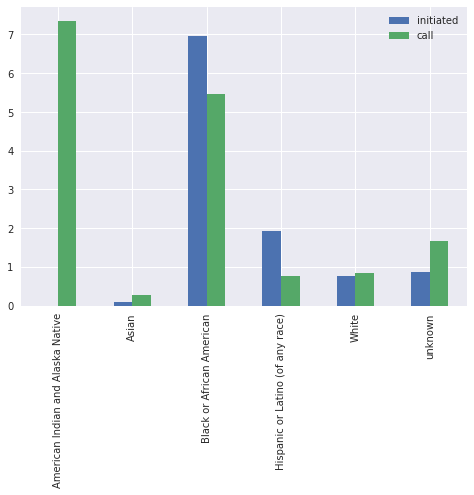

In [78]:
compare = pd.DataFrame({'initiated':fio_initiated_byrace.stop_liklihood,
                        'call':fio_call_byrace.stop_liklihood})
compare.plot(kind='bar')

### FIO by gender?

In [51]:
a = fio.groupby(['Race','Gender']).count()['Date/Time'].reset_index()
a['Race'] = a.Race.apply(map_demo_label)
a

,Race,Gender,Date/Time
0,Asian,M,6
1,Black or African American,F,11
2,Black or African American,M,33
3,Hispanic or Latino (of any race),F,3
4,Hispanic or Latino (of any race),M,8
5,Hispanic or Latino (of any race),U,1
6,American Indian and Alaska Native,M,1
7,unknown,F,1
8,unknown,M,6
9,unknown,U,2


In [53]:
fio.iloc[0]

Date/Time                                9/12/2015 20:49
Type/Offense                                         FIO
Location                    ALBEMARLE RD & NORTH ST (NV)
Race                                                   W
Gender                                                 M
Age                                                   75
Reason               Call for a male sleeping on a bench
Officer Initiated                                     No
Name: 0, dtype: object

# Traffic stops

In [ ]:
#Params
FP_TRAFFIC_DATA = 'data/NPD race and traffic stops.csv'
FP_FIG_CITATIONS_OUT = 'plots/citation_rate.svg'
assert os.path.exists(FP_TRAFFIC_DATA)

In [ ]:
traffic = pd.read_csv(FP_TRAFFIC_DATA)
traffic.head()

In [ ]:
traffic_black = traffic.groupby('Race/ethnicity').get_group('Black')
traffic_black.Warnings.sum()/traffic_black.Citations.sum()

In [ ]:
traffic_white = traffic.groupby('Race/ethnicity').get_group('White')
traffic_white.Warnings.sum()/traffic_white.Citations.sum()

In [ ]:
races = traffic['Race/ethnicity'].unique()
by_race = traffic.groupby('Race/ethnicity')
warnings = [by_race.get_group(race).Warnings.sum() for race in races]
citations = [by_race.get_group(race).Citations.sum() for race in races]
demo_proportion = []
for race in races:
    demo_mask = [race in demographic for demographic in demo.demographic]
    prop = demo.demo_proportion[demo_mask].values
    demo_proportion.append(prop[0])
traffic_proportionally = pd.DataFrame({'demographic':races,
                                       'warnings':warnings,
                                       'citations':citations,
                                       'demo_prop':demo_proportion})
traffic_proportionally['warn_prop'] = traffic_proportionally.warnings/traffic_proportionally.warnings.sum()
traffic_proportionally['cit_prop'] = traffic_proportionally.citations/traffic_proportionally.citations.sum()

In [ ]:
traffic_proportionally

In [ ]:
#calculate traffic stop outcomes proportionally

citations_proportional_demo = lambda x : x[5]/x[3]
traffic_proportionally['citation_rate'] = traffic_proportionally.apply(citations_proportional_demo,raw=True,axis=1)

warnings_proportional_demo = lambda x : x[4]/x[3]
traffic_proportionally['warning_rate'] = traffic_proportionally.apply(warnings_proportional_demo,raw=True,axis=1)

In [ ]:
traffic_proportionally

In [25]:
traffic_proportionally.set_index('demographic').drop('unknown').citation_rate.plot(kind='bar')
# plt.savefig(FP_FIG_CITATIONS_OUT)

NameError: name 'traffic_proportionally' is not defined

In [ ]:
likelihood_black = traffic_proportionally.set_index('demographic').loc['Black','citation_rate']/traffic_proportionally.set_index('demographic').loc['White','citation_rate']
print(f"If you're Black and driving in Newton you are {np.round(likelihood_black,3)} times more likely to get a traffic citation than if you're white")